In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import datetime
from skimage.feature import local_binary_pattern, hog
from skimage import color
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Importing Dataset


In [4]:
def load_dataset(dataset_path):
    images = []
    labels = []
    # Each subdirectory is a class corresponding to a person
    for person in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person)
        if os.path.isdir(person_path):
            # Only consider JPG images
            for file in os.listdir(person_path):
                if file.lower().endswith(".jpg"):
                    img_path = os.path.join(person_path, file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        images.append(img)
                        labels.append(person)
    return images, labels


dataset_path = 'VGG2_Dataset'
images, labels = load_dataset(dataset_path)
print(f"Loaded {len(images)} images for {len(set(labels))} persons.")


KeyboardInterrupt: 

In [ ]:
print("Number of images:", len(images))
print("Number of labels:", len(labels))
print("size of images:", images[0].shape)

Face Detection and Cropping (For Avoiding Background Noise)

No face detected in image: VGG2_Dataset\n000002\0017_01.jpg
No face detected in image: VGG2_Dataset\n000002\0018_01.jpg
No face detected in image: VGG2_Dataset\n000002\0018_04.jpg
No face detected in image: VGG2_Dataset\n000002\0023_01.jpg
No face detected in image: VGG2_Dataset\n000002\0026_01.jpg
No face detected in image: VGG2_Dataset\n000002\0031_01.jpg
No face detected in image: VGG2_Dataset\n000002\0031_02.jpg
No face detected in image: VGG2_Dataset\n000002\0031_03.jpg
No face detected in image: VGG2_Dataset\n000002\0031_04.jpg
No face detected in image: VGG2_Dataset\n000002\0031_05.jpg
No face detected in image: VGG2_Dataset\n000002\0048_01.jpg
No face detected in image: VGG2_Dataset\n000002\0058_01.jpg
No face detected in image: VGG2_Dataset\n000002\0075_01.jpg
No face detected in image: VGG2_Dataset\n000002\0094_01.jpg
No face detected in image: VGG2_Dataset\n000002\0095_01.jpg
No face detected in image: VGG2_Dataset\n000002\0098_01.jpg
No face detected in image: VGG2_Dataset\

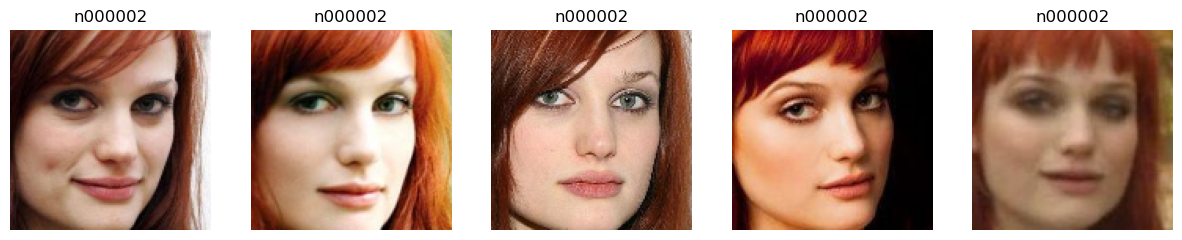

In [7]:
import os
import cv2
import matplotlib.pyplot as plt

def detect_and_crop_face(image, cascade_path='haarcascade_frontalface_default.xml'):
    """
    Detects faces in an image using Haar cascades and returns the cropped face region.
    
    Parameters:
    - image: Input image in BGR format.
    - cascade_path: Name of the Haar cascade XML file (default is for frontal face detection).
    
    Returns:
    - face_roi: Cropped face region if a face is detected; otherwise, returns None.
    - faces: List of detected face bounding boxes.
    """
    # Convert image to grayscale for detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + cascade_path)
    
    # Detect faces (tweak scaleFactor, minNeighbors, minSize as needed)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        return None, faces

    # Option: Choose the largest detected face
    (x, y, w, h) = sorted(faces, key=lambda b: b[2] * b[3], reverse=True)[0]
    face_roi = image[y:y+h, x:x+w]
    face_resized = cv2.resize(face_roi, (128, 128))
    return face_resized, faces

def load_dataset_with_face_detection(dataset_path):
    """
    Loads images from a dataset folder with one subfolder per person, applies face detection and cropping,
    and returns lists of cropped face images and corresponding labels.
    
    Parameters:
    - dataset_path: Path to the main dataset folder.
    
    Returns:
    - cropped_images: List of cropped face images.
    - labels: List of labels corresponding to each image.
    """
    cropped_images = []
    labels = []
    
    # Iterate over each person's folder
    for person in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person)
        if os.path.isdir(person_path):
            # Process only .jpg files
            for file in os.listdir(person_path):
                if file.lower().endswith('.jpg'):
                    img_path = os.path.join(person_path, file)
                    image = cv2.imread(img_path)
                    if image is None:
                        continue
                    # Apply face detection and crop the face
                    face, _ = detect_and_crop_face(image)
                    if face is not None:
                        cropped_images.append(face)
                        labels.append(person)
                    else:
                        print(f"No face detected in image: {img_path}")
    
    return cropped_images, labels

def display_images(images, labels, num_samples=5):
    """
    Displays a few sample images with their labels in a Jupyter Notebook using Matplotlib.
    
    Parameters:
    - images: List of images in BGR format.
    - labels: Corresponding labels.
    - num_samples: Number of samples to display.
    """
    num_samples = min(num_samples, len(images))
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img = images[i]
        label = labels[i]
        # Convert from BGR to RGB for correct color display
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img_rgb)
        plt.title(label)
        plt.axis('off')
    plt.show()

# Example usage in a Jupyter Notebook:
dataset_path = 'VGG2_Dataset'  # Update with your dataset location
images, labels = load_dataset_with_face_detection(dataset_path)
print(f"Loaded {len(images)} cropped face images for {len(set(labels))} persons.")

# Display a few sample images inline
display_images(images, labels, num_samples=5)


Example usage of face detection and cropping

Detected 1 face(s) in the image.
Detected face: [[[ 12  11   7]
  [ 20  18  17]
  [ 24  22  21]
  ...
  [166  93  43]
  [171  95  42]
  [171  94  38]]

 [[ 16  17  15]
  [ 20  20  20]
  [ 22  22  22]
  ...
  [170  94  45]
  [171  93  40]
  [169  89  34]]

 [[ 17  19  19]
  [ 20  22  22]
  [ 21  23  23]
  ...
  [172  95  46]
  [175  95  42]
  [172  92  37]]

 ...

 [[234 235 239]
  [238 241 246]
  [224 226 234]
  ...
  [151  94  39]
  [166 102  44]
  [174 101  43]]

 [[234 235 239]
  [239 242 247]
  [227 229 237]
  ...
  [153  93  39]
  [170 103  46]
  [178 104  46]]

 [[236 237 241]
  [243 243 249]
  [231 233 241]
  ...
  [161  97  42]
  [174 104  45]
  [179 103  44]]]
Detected face shape: (85, 85, 3)


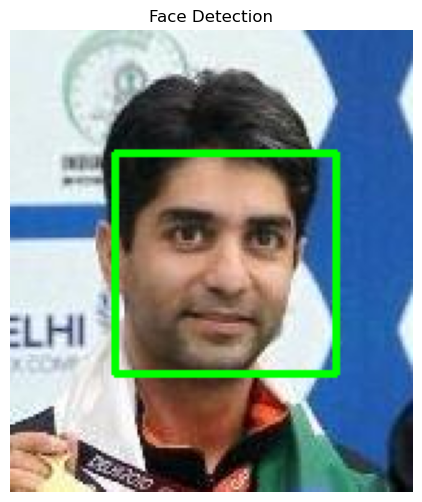

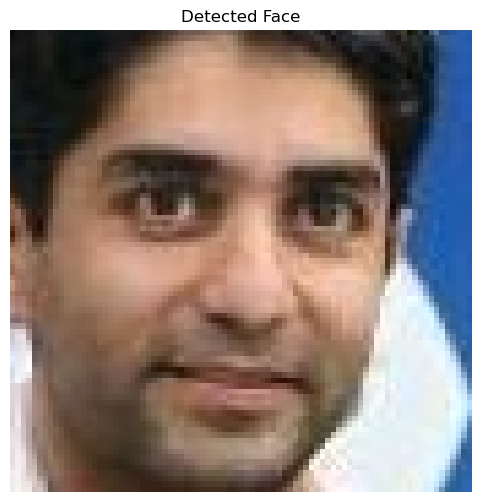

In [25]:
import cv2
import matplotlib.pyplot as plt

def detect_and_crop_face(image, cascade_path='haarcascade_frontalface_default.xml'):
    """
    Detects faces in an image using Haar cascades and returns the cropped face region.
    
    Parameters:
    - image: Input image (BGR format)
    - cascade_path: Filename for the Haar cascade XML file.
    
    Returns:
    - face_roi: Cropped face region if a face is detected; otherwise, returns None.
    - faces: List of detected face bounding boxes.
    """
    # Convert image to grayscale for the face detector
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Load Haar cascade from OpenCV's data directory
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + cascade_path)
    
    # Detect faces: adjust scaleFactor and minNeighbors as needed
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        print("No faces detected.")
        return None, faces

    # For demonstration, take the first detected face (or choose the largest face)
    (x, y, w, h) = sorted(faces, key=lambda b: b[2] * b[3], reverse=True)[0]
    face_roi = image[y:y+h, x:x+w]
    face_resized = cv2.resize(face_roi, (128, 128))
    # return face_resized, faces
    return face_roi, faces

def show_image(title, image, cmap=None):
    """
    Displays an image using Matplotlib.
    
    Parameters:
    - title: Title of the plot.
    - image: Image array.
    - cmap: Color map (if needed, e.g., 'gray' for grayscale images).
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Example usage in Jupyter Notebook:
img_path = r"C:\Users\varchasva\OneDrive\Documents\prmlproject\VGG2_Dataset\n000033\0001_01.jpg"  # Update with your image path
image = cv2.imread(img_path)

if image is None:
    print("Image not found or unable to load.")
else:
    face, faces = detect_and_crop_face(image)
    print(f"Detected {len(faces)} face(s) in the image.")
    print(f"Detected face: {face}")
    print(f"Detected face shape: {face.shape if face is not None else None}")
    
    # Convert images from BGR to RGB for proper display in Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if face is not None:
        face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        # Draw rectangles on the original image for visualization
        for (x, y, w, h) in faces:
            cv2.rectangle(image_rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # Display the original image with detected face boxes
        show_image("Face Detection", image_rgb)
        
        # Display the cropped face
        show_image("Detected Face", face_rgb)
    else:
        print("No face detected in the image.")


Seeing how an image is  resized

Original image shape: (178, 155, 3)
Resized image shape: (200, 200, 3)


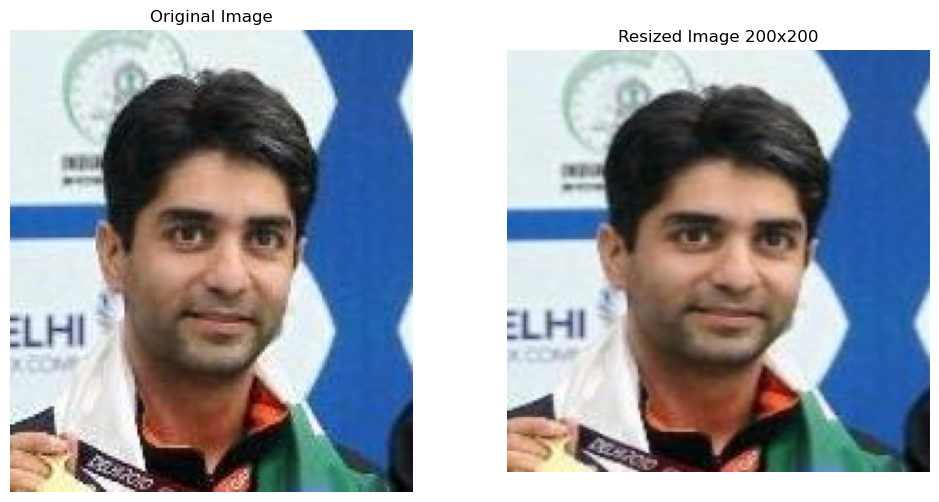

In [27]:
import cv2
import matplotlib.pyplot as plt

# Load the image (update 'path/to/your/image.jpg' with your image path)
image = cv2.imread(r"C:\Users\varchasva\OneDrive\Documents\prmlproject\VGG2_Dataset\n000033\0001_01.jpg")

# Check if image was loaded
if image is None:
    print("Image not found or unable to load.")
else:
    # Print the original image dimensions
    print("Original image shape:", image.shape)

    # Define the target size (width, height)
    target_size = (200, 200)

    # Resize the image to the target size
    resized_image = cv2.resize(image, target_size)
    print("Resized image shape:", resized_image.shape)

    # Convert images from BGR (OpenCV default) to RGB for correct display in Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    # Display the original and resized images side by side
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis('off')

    # Resized image
    plt.subplot(1, 2, 2)
    plt.imshow(resized_rgb)
    plt.title(f"Resized Image {target_size[0]}x{target_size[1]}")
    plt.axis('off')

    plt.show()


In [28]:
print(images[0].shape)
print(images[0])
print(images[1])
print(labels[0])
print(labels[1])

(128, 128, 3)
[[[ 10  29  79]
  [ 16  32  79]
  [ 26  38  81]
  ...
  [225 223 226]
  [241 240 242]
  [245 245 245]]

 [[ 10  30  81]
  [ 24  40  87]
  [ 19  29  73]
  ...
  [213 212 215]
  [227 226 228]
  [229 229 229]]

 [[ 24  40  82]
  [ 20  33  78]
  [ 16  26  73]
  ...
  [205 205 212]
  [217 215 218]
  [224 219 219]]

 ...

 [[ 22  26  55]
  [ 20  22  46]
  [ 16  15  35]
  ...
  [242 242 242]
  [241 241 241]
  [244 242 242]]

 [[  7  12  40]
  [ 20  23  47]
  [ 23  22  41]
  ...
  [239 239 239]
  [240 240 240]
  [247 245 245]]

 [[ 14  16  39]
  [ 22  23  45]
  [ 16  17  37]
  ...
  [235 234 238]
  [242 241 245]
  [248 245 247]]]
[[[ 25  49 149]
  [ 13  36 137]
  [ 21  43 145]
  ...
  [120 169 159]
  [113 163 149]
  [117 167 149]]

 [[ 28  50 150]
  [  2  25 125]
  [ 22  45 146]
  ...
  [121 172 165]
  [112 165 152]
  [109 162 145]]

 [[ 20  39 137]
  [  9  33 128]
  [ 30  55 149]
  ...
  [127 176 175]
  [112 166 156]
  [106 161 143]]

 ...

 [[ 10  29 108]
  [ 22  39 119]
  [ 17

Extracting LBP features of the Images

In [32]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern

def extract_lbp_features(image, radius=1, n_points=8):
    """
    Extract LBP features from an image.
    
    Parameters:
    - image: Input image in BGR or grayscale.
    - radius: Radius of circle (in pixels) for LBP.
    - n_points: Number of points to consider around each pixel.
    
    Returns:
    - hist: Normalized histogram of LBP features.
    """
    # If the image has 3 channels, convert it to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Compute the LBP representation of the image using the "uniform" method
    lbp = local_binary_pattern(gray, n_points, radius, method="uniform")
    
    # Calculate the number of bins. For uniform LBP, the number of bins is n_points + 2
    n_bins = int(n_points + 2)
    
    # Build a histogram of the LBP values
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    
    # Normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    
    return hist

# Example usage:
example_image = cv2.imread('project_data\lfw-deepfunneled\lfw-deepfunneled\Zach_Parise\Zach_Parise_0001.jpg')
lbp_features = extract_lbp_features(example_image)
print("LBP features:", lbp_features)
print("LBP features shape:", lbp_features.shape)


LBP features: [0.00824  0.037824 0.015312 0.085536 0.245392 0.196112 0.052624 0.05176
 0.25808  0.04912 ]
LBP features shape: (10,)


HoG features of the images


In [33]:
from skimage.feature import hog

def extract_hog_features(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    """
    Extract HoG features from an image.
    
    Parameters:
    - image: Input image in BGR format.
    - pixels_per_cell: Size (in pixels) of a cell.
    - cells_per_block: Number of cells in each block.
    - orientations: Number of gradient orientations.
    
    Returns:
    - hog_features: A feature vector containing the HoG features.
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute the HoG features
    hog_features = hog(gray,
                       orientations=orientations,
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       block_norm='L2-Hys',
                       visualize=False,
                       feature_vector=True)
    
    return hog_features

# Example usage:
hog_features = extract_hog_features(example_image)
print("HoG features:", hog_features)
print("HoG features shape:", hog_features.shape)

HoG features: [0.         0.         0.         ... 0.07919211 0.         0.        ]
HoG features shape: (32400,)


Without CNN

In [34]:
def extract_all_features_no_cnn(images):
    """
    images: NumPy array of shape (n_samples, 128, 128, 3)
    Returns: combined features of shape (n_samples, combined_feature_length)
    """
    all_features = []
    for idx, img in enumerate(images):
        # Extract features from each image
        # pixel_feat = img.flatten()
        hog_feat = extract_hog_features(img)
        bnp_feat = extract_lbp_features(img)
        # cnn_feat = extract_cnn_features(img)
        
        # Concatenate all features into one vector
        # combined = np.concatenate([pixel_feat, hog_feat, bnp_feat])

        
        # Without pixel features
        combined = np.concatenate([hog_feat, bnp_feat])
        all_features.append(combined)
    return np.array(all_features)

In [35]:
without_cnn_features=extract_all_features_no_cnn(images)
print("Features shape:", without_cnn_features.shape)

KeyboardInterrupt: 

Creating Dataframe 

In [ ]:
import pandas as pd

df = pd.DataFrame(without_cnn_features)

# Generate column names for features
df.columns = [f'feature_{i}' for i in range(without_cnn_features.shape[1])]

# Add the labels column
df['label'] = labels  # Ensure 'labels' has the same length as features

# Display the shape to confirm
print("DataFrame shape:", df.shape)

# Show first few rows
print(df.head())


DataFrame shape: (13149, 8111)
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.213875   0.000000   0.027484   0.204814   0.092647   0.059579   
1   0.294482   0.101196   0.053335   0.000000   0.196110   0.057584   
2   0.263874   0.115432   0.182514   0.028858   0.263874   0.028858   
3   0.260193   0.260193   0.161491   0.087980   0.260193   0.135941   
4   0.099426   0.074936   0.264372   0.264372   0.196432   0.142947   

   feature_6  feature_7  feature_8  feature_9  ...  feature_8101  \
0   0.020905   0.211034   0.313290   0.253203  ...      0.024048   
1   0.042668   0.067464   0.054952   0.294482  ...      0.022583   
2   0.182514   0.208496   0.000000   0.193585  ...      0.018982   
3   0.041394   0.049647   0.096214   0.260193  ...      0.026367   
4   0.038829   0.020692   0.074532   0.264372  ...      0.028809   

   feature_8102  feature_8103  feature_8104  feature_8105  feature_8106  \
0      0.021667      0.121033      0.440552      0.245300 

OneHotEncoding for labels


In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# # Apply One-Hot Encoding
# one_hot_encoder = OneHotEncoder(sparse_output=False) 
# encoded_labels = one_hot_encoder.fit_transform(df[['label']])  # Convert labels to one-hot encoding

# # Convert to DataFrame with proper column names
# label_columns = [f'label_{i}' for i in range(encoded_labels.shape[1])]

# df_encoded = pd.DataFrame(encoded_labels, columns=label_columns)

# # Drop original label column and concatenate encoded labels
# df = df.drop(columns=['label'])
# df = pd.concat([df, df_encoded], axis=1)


In [ ]:
# print(df.head())  # Display first few rows

In [ ]:
from sklearn.model_selection import train_test_split

# Features (X) and Labels (y)
# num_classes = len(set(labels))
# X = df.drop(columns=[f"label_{i}" for i in range(num_classes)])  # Feature matrix
# y = df[[f"label_{i}" for i in range(num_classes)]]  # One-hot encoded labels

X=df.drop(columns=['label'])
y=df['label']

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # y contains names of persons

# Train-Test Split (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")


Applying ML model

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)  # X is your feature matrix

NameError: name 'X' is not defined

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)  # Adjust based on variance plot
X_pca = pca.fit_transform(X_normalized)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")


Training set size: (10519, 100), Test set size: (2630, 100)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=50,  # Reduce trees for faster training
    max_depth=15,     # Limit depth to prevent overfitting
    min_samples_split=5,  # Require more samples per split (reduces overfitting)
    n_jobs=-1,  # Use all CPU cores for parallel processing
    random_state=42
)

rf_model.fit(X_train, y_train)
print(f"Random Forest Accuracy: {rf_model.score(X_test, y_test):.4f}")

Random Forest Accuracy: 0.0802
